In [1]:
!pip install pandas-plink limix-lmm

In [2]:
import numpy as np
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [3]:
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

### Preprocessing pipeline (run in shell)
plink --bfile 
/Users/malenavoss/GoBi_Theis/GWAS_Blockteil/gobi_gwas/malena_v/raw/ALL.chr22_GRCh38.genotypes.20170504 \
      --snps-only \
      --geno 0.02 \
      --maf 0.01 \
      --make-bed \
      --out chr22_qc_step1

In [4]:
bfile = '/Users/malenavoss/GoBi_Theis/Blockteil/gobi_gwas/oyku/data/qc/chr22_step3_sampleqc'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]
/Users/malenavoss/GoBi_Theis/Blockteil/gobi_gwas/.venv/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [5]:
n_snps, n_samples = bim.shape[0], fam.shape[0]
n_snps, n_samples

(59743, 2504)

In [7]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return fam, G

In [8]:
X_real = G.compute().T
mu_full = X_real.mean(axis=0)
sd_full = X_real.std(axis=0, ddof=0)
keep_full = sd_full > 1e-12
keep_idx = np.where(keep_full)[0]
standardized_X = (X_real[:, keep_full] - mu_full[keep_full]) / sd_full[keep_full]
bim_kept = bim.iloc[keep_idx].copy().reset_index(drop=True)
bim_kept['orig_bim_idx'] = keep_idx

### Phase 1: Phenotype Simulation

In [9]:
BASE_SEED = 42

def seed_for(h2, m, base=BASE_SEED):
    h2_int = int(round(h2 * 1_000_000))  
    return base + 1_000_003 * h2_int + 10_007 * int(m)

In [10]:
M, h2 = 10, 0.6
rng = np.random.default_rng(seed_for(h2, M))
idx_caus = np.random.choice(standardized_X.shape[1], size=M)
var_expl = np.repeat(h2/M, M)

In [11]:
def simulate_pheno(X, idx_caus, var_expl, rng, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (rng.random(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * rng.standard_normal((X.shape[0], 1))

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [12]:
def qq_plot(p_values, title):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

In [13]:
y, beta_real = simulate_pheno(standardized_X, idx_caus, var_expl, rng)

In [14]:
y.shape

(2504, 1)

In [15]:
pheno = fam[["fid","iid"]].copy()
pheno.columns = ["FID","IID"]
pheno["y"] = y.reshape(-1)

In [16]:
pcs = pd.read_csv("//Users/malenavoss/GoBi_Theis/Blockteil/gobi_gwas/malena_v/PLINK/PCA/chr22_pca.eigenvec", sep=r"\s+", header=None, engine="python")
pcs.columns = ["FID","IID"] + [f"PC{i}" for i in range(1, pcs.shape[1]-1)]

df = pheno.merge(pcs, on=["FID","IID"], how="inner", validate="one_to_one")

In [17]:
k = 10
F = np.column_stack([np.ones((df.shape[0], 1)),
                     df[[f"PC{i}" for i in range(1, k+1)]].to_numpy()])

In [18]:
df[['FID','IID']].to_csv('/Users/malenavoss/GoBi_Theis/Blockteil/gobi_gwas/malena_v/df_samples.txt', sep=' ', index=False, header=False)


Filter nach samples
plink --bfile chr22_step3_sampleqc \
      --keep keep_samples.txt \
      --make-bed \
      --out chr22_filtered_samples

Jetzt gibt es file mit nur gefilterten Genotypen

### Phase 2: GWAS / Feature Selection

#### 1. Training/Validation Set Split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, F_train, F_test = train_test_split(
    standardized_X, y, F,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

In [20]:
X_train.shape, y_train.shape, F_train.shape

((1752, 59740), (1752, 1), (1752, 11))

#### 2. GWAS (training set only)

In [21]:
lmm = LMM(y_train, F_train)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

In [22]:
pv.shape

(59740,)

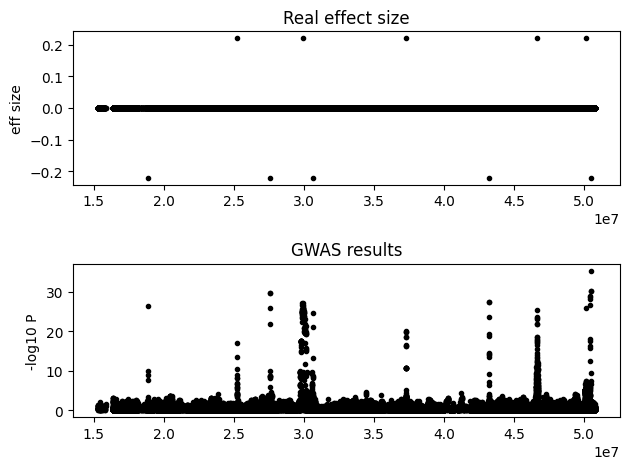

In [23]:
x = bim_kept['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log10 P')
plt.tight_layout()
plt.show()

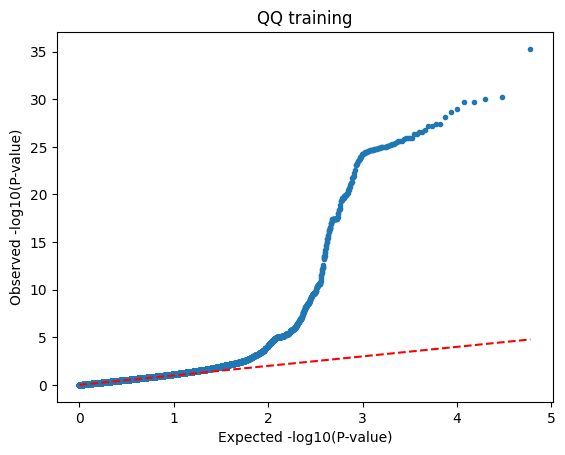

In [24]:
qq_plot(pv, 'QQ training')
plt.show()

#### 3. Clumping 

Leakage prevention: LD and SNP selection from training only.

In [31]:
if len(bim) != len(pv):
    valid_idx = ~np.isnan(pv) 
    bim_filtered = bim.iloc[valid_idx].reset_index(drop=True)
    pv_filtered = pv[valid_idx]
else:
    bim_filtered = bim.copy()
    pv_filtered = pv


gwas_df = pd.DataFrame({
    'CHR': bim_filtered['chrom'],
    'SNP': bim_filtered['snp'],
    'BP': bim_filtered['pos'],
    'P': pv_filtered
})


gwas_df.to_csv("gwas_results.txt", sep="\t", index=False)
print(f"GWAS file ready: {gwas_df.shape[0]} SNPs")


IndexError: Boolean index has wrong length: 59740 instead of 59743

### Phase 3: Model Development

In [99]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr


